In [3]:
import pandas as pd
import warnings
import xarray as xr
from datetime import datetime, timedelta
import math
import numpy as np
warnings.filterwarnings('ignore')

# Get today's date
today = datetime.today()
# Calculate the date 3 days ago
three_days_ago = today - timedelta(days=3)
# Format the date as text
start_text = today.strftime("%Y%m%d")
end_text = three_days_ago.strftime("%Y%m%d")

#december
date_start = datetime(2023, 12, 6)
date_end = datetime(2023, 12, 13)
start_text = today.strftime("%Y%m%d")
end_text = three_days_ago.strftime("%Y%m%d")

#name='https://api.tidesandcurrents.noaa.gov/api/prod/datagetter?product=air_temperature&application=NOS.COOPS.TAC.MET&begin_date=20240822&end_date=20240823&station=8723214&time_zone=GMT&units=english&interval=6&format=csv'
#df_buoy = pd.read_csv(fname, delim_whitespace=True)

astation_hollywood = '41122' #hollywood beach (just north of south beach)
astation_virkey='VAKF1'
astation_virkey2 = '8723214' #rsmas buoy
#astation2 = 'VAKF1.txt'

#45 day nrt data from noaa site
fname_holly = 'https://www.ndbc.noaa.gov/data/realtime2/'+astation_hollywood+'.txt'
fname_vkey = 'https://www.ndbc.noaa.gov/data/realtime2/'+astation_virkey+'.txt'
fname_vkey_tide = 'https://api.tidesandcurrents.noaa.gov/api/prod/datagetter?product=predictions&application=NOS.COOPS.TAC.WL&begin_date='+end_text+'&end_date='+start_text+'&datum=MLLW&station='+astation_virkey2+'&time_zone=GMT&units=english&interval=&format=csv'
print(fname_vkey_tide)
#from tides and currents, sometimes has better idea than noaa site above
#fname_water_level = 'https://api.tidesandcurrents.noaa.gov/api/prod/datagetter?product=water_level&application=NOS.COOPS.TAC.WL&begin_date='+three_days_ago_text+'&end_date='+date_text+'&datum=MLLW&station='+astation+'&time_zone=GMT&units=english&format=csv'

#fname_water_level
#df_water = pd.read_csv(fname_water_level, delim_whitespace=False)
#df_tide = pd.read_csv(fname_vkey_tide, delim_whitespace=False)
#df_datum = pd.read_json(fname_datum)

def get_nrt_buoy(fname): 
    df_buoy = pd.read_csv(fname, delim_whitespace=True, header=0, parse_dates=True,na_values='MM')
    df_buoy_units=df_buoy[:][0:1] #remove row that has units
    df_buoy=df_buoy[:][1:len(df_buoy)] #remove row that has units
    df_buoy.insert(0,'Year',df_buoy['#YY'])
    df_buoy.insert(1,'Month',df_buoy['MM'])
    df_buoy.insert(2,'Day',df_buoy['DD'])
    df_buoy.insert(2,'hour',df_buoy['hh'])
    df_buoy.insert(2,'minute',df_buoy['mm'])
    df_buoy.insert(0,'time',pd.to_datetime(df_buoy[list(df_buoy)[0:5]]))
    df_buoy=df_buoy.drop(columns={'Year','Month','minute','hour','Day','hh','mm','DD','MM','#YY'})
    df_buoy = df_buoy.set_index(['time'])
    df_buoy = df_buoy.astype('float64')
    ds_buoy = df_buoy.to_xarray()
    ds_buoy = ds_buoy.sortby(ds_buoy.time,ascending=True)
    return ds_buoy

https://api.tidesandcurrents.noaa.gov/api/prod/datagetter?product=predictions&application=NOS.COOPS.TAC.WL&begin_date=20240903&end_date=20240906&datum=MLLW&station=8723214&time_zone=GMT&units=english&interval=&format=csv


In [2]:
ds_holly = get_nrt_buoy(fname_holly)
ds_holly = ds_holly.sel(time=slice(three_days_ago_text,date_text))
ds_key = get_nrt_buoy(fname_vkey)
ds_key = ds_key.sel(time=slice(three_days_ago_text,date_text))

#get predicted tide from virginia key 
df_tide = pd.read_csv(fname_vkey_tide, delim_whitespace=False,parse_dates=True)
#df_buoy.insert(1,'time64',pd.to_datetime(df_tide[0]))
df_tide.insert(0,'time',pd.to_datetime(df_tide['Date Time']))
df_tide.insert(2,'tide_predicted',df_tide[' Prediction'])
df_tide=df_tide.drop(columns={'Date Time',' Prediction'})
df_tide = df_tide.set_index(['time'])
ds_tide = df_tide.to_xarray()
ds_tide

<xarray.Dataset> Size: 15kB
Dimensions:         (time: 960)
Coordinates:
  * time            (time) datetime64[ns] 8kB 2024-08-23 ... 2024-08-26T23:54:00
Data variables:
    tide_predicted  (time) float64 8kB 0.716 0.775 0.835 ... 0.948 0.913 0.879

In [3]:
ds_key

<xarray.Dataset> Size: 111kB
Dimensions:  (time: 924)
Coordinates:
  * time     (time) datetime64[ns] 7kB 2024-08-23 ... 2024-08-26T20:18:00
Data variables: (12/14)
    WDIR     (time) float64 7kB 360.0 360.0 350.0 360.0 ... 70.0 70.0 70.0 80.0
    WSPD     (time) float64 7kB 1.5 1.5 1.0 1.0 1.0 1.5 ... 4.1 3.6 3.6 3.6 4.1
    GST      (time) float64 7kB 3.1 3.1 2.6 2.6 2.6 3.1 ... 4.6 4.6 5.1 5.1 5.1
    WVHT     (time) float64 7kB nan nan nan nan nan nan ... nan nan nan nan nan
    DPD      (time) float64 7kB nan nan nan nan nan nan ... nan nan nan nan nan
    APD      (time) float64 7kB nan nan nan nan nan nan ... nan nan nan nan nan
    ...       ...
    ATMP     (time) float64 7kB 27.5 27.5 27.5 27.5 27.4 ... 30.4 30.3 30.4 30.3
    WTMP     (time) float64 7kB 30.3 30.3 30.3 30.3 30.3 ... 30.2 30.2 30.2 30.2
    DEWP     (time) float64 7kB nan nan nan nan nan nan ... nan nan nan nan nan
    VIS      (time) float64 7kB nan nan nan nan nan nan ... nan nan nan nan nan
    PTDY     (time) float64 7kB -0.0 nan nan nan nan ... nan -1.3 nan nan nan
    TIDE     (time) float64 7kB nan nan nan nan nan nan ... nan nan nan nan nan

In [4]:
ds_holly

<xarray.Dataset> Size: 15kB
Dimensions:  (time: 129)
Coordinates:
  * time     (time) datetime64[ns] 1kB 2024-08-23T00:26:00 ... 2024-08-26T20:...
Data variables: (12/14)
    WDIR     (time) float64 1kB nan nan nan nan nan nan ... nan nan nan nan nan
    WSPD     (time) float64 1kB nan nan nan nan nan nan ... nan nan nan nan nan
    GST      (time) float64 1kB nan nan nan nan nan nan ... nan nan nan nan nan
    WVHT     (time) float64 1kB 0.3 0.3 0.3 0.3 0.4 0.6 ... 0.5 0.6 0.6 0.6 0.6
    DPD      (time) float64 1kB 4.0 12.0 4.0 11.0 11.0 ... 4.0 4.0 4.0 4.0 4.0
    APD      (time) float64 1kB 2.7 3.1 2.9 2.8 2.8 3.0 ... 3.5 3.5 3.4 3.5 3.5
    ...       ...
    ATMP     (time) float64 1kB nan nan nan nan nan nan ... nan nan nan nan nan
    WTMP     (time) float64 1kB 29.7 29.7 29.6 29.6 29.6 ... 30.0 30.0 30.0 30.0
    DEWP     (time) float64 1kB nan nan nan nan nan nan ... nan nan nan nan nan
    VIS      (time) float64 1kB nan nan nan nan nan nan ... nan nan nan nan nan
    PTDY     (time) float64 1kB nan nan nan nan nan nan ... nan nan nan nan nan
    TIDE     (time) float64 1kB nan nan nan nan nan nan ... nan nan nan nan nan

In [5]:
#interpolate the hollywood data onto the virginia key data times
ds_hollyi = ds_holly.interp(time=ds_key.time)
ds_buoy=ds_hollyi.copy()
ds_buoy['WDIR']=ds_key['WDIR']
ds_buoy['WSPD']=ds_key['WSPD']
ds_buoy['GST']=ds_key['GST']
ds_buoy['PRES']=ds_key['PRES']
ds_buoy['ATMP']=ds_key['ATMP']
ds_buoy['WTMP']=ds_key['WTMP']
ds_buoy

<xarray.Dataset> Size: 111kB
Dimensions:  (time: 924)
Coordinates:
  * time     (time) datetime64[ns] 7kB 2024-08-23 ... 2024-08-26T20:18:00
Data variables: (12/14)
    WDIR     (time) float64 7kB 360.0 360.0 350.0 360.0 ... 70.0 70.0 70.0 80.0
    WSPD     (time) float64 7kB 1.5 1.5 1.0 1.0 1.0 1.5 ... 4.1 3.6 3.6 3.6 4.1
    GST      (time) float64 7kB 3.1 3.1 2.6 2.6 2.6 3.1 ... 4.6 4.6 5.1 5.1 5.1
    WVHT     (time) float64 7kB nan nan nan nan nan 0.3 ... 0.6 0.6 0.6 0.6 0.6
    DPD      (time) float64 7kB nan nan nan nan nan ... 4.0 4.0 4.0 4.0 4.0
    APD      (time) float64 7kB nan nan nan nan nan ... 3.5 3.5 3.5 3.5 3.5
    ...       ...
    ATMP     (time) float64 7kB 27.5 27.5 27.5 27.5 27.4 ... 30.4 30.3 30.4 30.3
    WTMP     (time) float64 7kB 30.3 30.3 30.3 30.3 30.3 ... 30.2 30.2 30.2 30.2
    DEWP     (time) float64 7kB nan nan nan nan nan nan ... nan nan nan nan nan
    VIS      (time) float64 7kB nan nan nan nan nan nan ... nan nan nan nan nan
    PTDY     (time) float64 7kB nan nan nan nan nan nan ... nan nan nan nan nan
    TIDE     (time) float64 7kB nan nan nan nan nan nan ... nan nan nan nan nan

In [6]:
ds_buoy

<xarray.Dataset> Size: 111kB
Dimensions:  (time: 924)
Coordinates:
  * time     (time) datetime64[ns] 7kB 2024-08-23 ... 2024-08-26T20:18:00
Data variables: (12/14)
    WDIR     (time) float64 7kB 360.0 360.0 350.0 360.0 ... 70.0 70.0 70.0 80.0
    WSPD     (time) float64 7kB 1.5 1.5 1.0 1.0 1.0 1.5 ... 4.1 3.6 3.6 3.6 4.1
    GST      (time) float64 7kB 3.1 3.1 2.6 2.6 2.6 3.1 ... 4.6 4.6 5.1 5.1 5.1
    WVHT     (time) float64 7kB nan nan nan nan nan 0.3 ... 0.6 0.6 0.6 0.6 0.6
    DPD      (time) float64 7kB nan nan nan nan nan ... 4.0 4.0 4.0 4.0 4.0
    APD      (time) float64 7kB nan nan nan nan nan ... 3.5 3.5 3.5 3.5 3.5
    ...       ...
    ATMP     (time) float64 7kB 27.5 27.5 27.5 27.5 27.4 ... 30.4 30.3 30.4 30.3
    WTMP     (time) float64 7kB 30.3 30.3 30.3 30.3 30.3 ... 30.2 30.2 30.2 30.2
    DEWP     (time) float64 7kB nan nan nan nan nan nan ... nan nan nan nan nan
    VIS      (time) float64 7kB nan nan nan nan nan nan ... nan nan nan nan nan
    PTDY     (time) float64 7kB nan nan nan nan nan nan ... nan nan nan nan nan
    TIDE     (time) float64 7kB nan nan nan nan nan nan ... nan nan nan nan nan

In [7]:
ds_tidei = ds_tide.interp(time=ds_buoy.time)
ds_buoy['tide_predicted']=ds_tidei['tide_predicted']
ds_buoy

<xarray.Dataset> Size: 118kB
Dimensions:         (time: 924)
Coordinates:
  * time            (time) datetime64[ns] 7kB 2024-08-23 ... 2024-08-26T20:18:00
Data variables: (12/15)
    WDIR            (time) float64 7kB 360.0 360.0 350.0 ... 70.0 70.0 80.0
    WSPD            (time) float64 7kB 1.5 1.5 1.0 1.0 1.0 ... 3.6 3.6 3.6 4.1
    GST             (time) float64 7kB 3.1 3.1 2.6 2.6 2.6 ... 4.6 5.1 5.1 5.1
    WVHT            (time) float64 7kB nan nan nan nan nan ... 0.6 0.6 0.6 0.6
    DPD             (time) float64 7kB nan nan nan nan nan ... 4.0 4.0 4.0 4.0
    APD             (time) float64 7kB nan nan nan nan nan ... 3.5 3.5 3.5 3.5
    ...              ...
    WTMP            (time) float64 7kB 30.3 30.3 30.3 30.3 ... 30.2 30.2 30.2
    DEWP            (time) float64 7kB nan nan nan nan nan ... nan nan nan nan
    VIS             (time) float64 7kB nan nan nan nan nan ... nan nan nan nan
    PTDY            (time) float64 7kB nan nan nan nan nan ... nan nan nan nan
    TIDE            (time) float64 7kB nan nan nan nan nan ... nan nan nan nan
    tide_predicted  (time) float64 7kB 0.716 0.775 0.835 ... 2.262 2.241 2.217

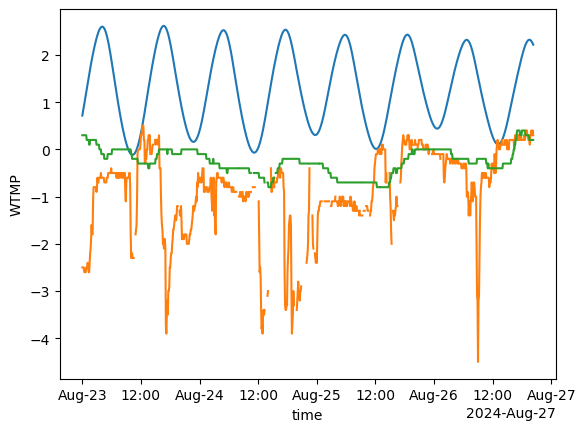

In [8]:
ds_buoy['tide_predicted'].plot()
(ds_buoy['ATMP']-30).plot()
(ds_buoy['WTMP']-30).plot()

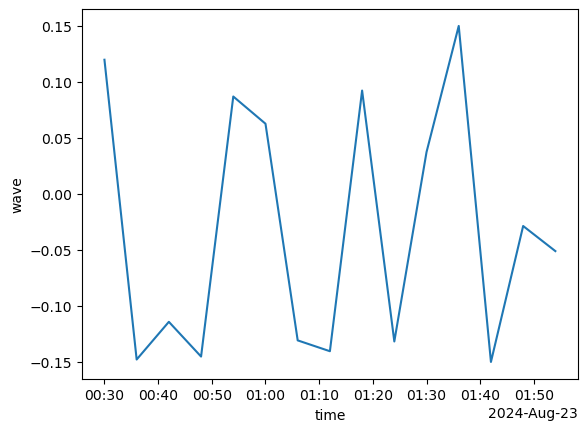

In [9]:
#make the waves
#APD Average wave period (seconds)
t= (ds_buoy.time-ds_buoy.time[0])*1e-9 # in seconds
ds_buoy['tsec']=t.astype('float32')
ds_buoy['wave'] = ds_buoy.WVHT/2 * np.sin(2 * np.pi * ds_buoy.tsec / ds_buoy.APD)
ds_buoy.wave[0:20].plot()

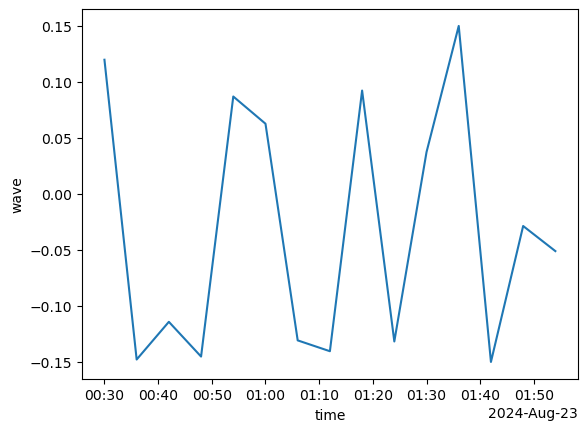

In [10]:
#make the waves
#APD Average wave period (seconds)
t= (ds_buoy.time-ds_buoy.time[0])*1e-9 # in seconds
ds_buoy['tsec']=t.astype('float32')
ds_buoy['wave'] = ds_buoy.WVHT/2 * np.sin(2 * np.pi * ds_buoy.tsec / ds_buoy.APD)
ds_buoy.wave[0:20].plot()

In [11]:
#create fake data with 1 second data for last 3 days
time_range = pd.date_range(start=three_days_ago_text, end=date_text, freq='S')
# Generate some example data (e.g., random data)
data = np.random.rand(len(time_range))
ds_wave = xr.Dataset({"wave": (["time"], data),},coords={"time": time_range,})
ds_wave

<xarray.Dataset> Size: 4MB
Dimensions:  (time: 259201)
Coordinates:
  * time     (time) datetime64[ns] 2MB 2024-08-23 ... 2024-08-26
Data variables:
    wave     (time) float64 2MB 0.2169 0.8864 0.7966 ... 0.3732 0.4571 0.8651

In [12]:
ds_buoy2 = ds_buoy.interp(time=ds_wave.time)
ds_buoy2

<xarray.Dataset> Size: 37MB
Dimensions:         (time: 259201)
Coordinates:
  * time            (time) datetime64[ns] 2MB 2024-08-23 ... 2024-08-26
Data variables: (12/17)
    WDIR            (time) float64 2MB 360.0 360.0 360.0 360.0 ... nan nan nan
    WSPD            (time) float64 2MB 1.5 1.5 1.5 1.5 1.5 ... nan nan nan nan
    GST             (time) float64 2MB 3.1 3.1 3.1 3.1 3.1 ... nan nan nan nan
    WVHT            (time) float64 2MB nan nan nan nan nan ... 0.4 0.4 0.4 0.4
    DPD             (time) float64 2MB nan nan nan nan nan ... 4.0 4.0 4.0 4.0
    APD             (time) float64 2MB nan nan nan nan nan ... 3.1 3.1 3.1 3.1
    ...              ...
    VIS             (time) float64 2MB nan nan nan nan nan ... nan nan nan nan
    PTDY            (time) float64 2MB nan nan nan nan nan ... nan nan nan nan
    TIDE            (time) float64 2MB nan nan nan nan nan ... nan nan nan nan
    tide_predicted  (time) float64 2MB 0.716 0.7162 0.7163 ... 0.492 0.492
    tsec            (time) float64 2MB 0.0 1.0 2.0 ... 2.592e+05 2.592e+05
    wave            (time) float64 2MB nan nan nan ... -0.1134 -0.114 -0.1146

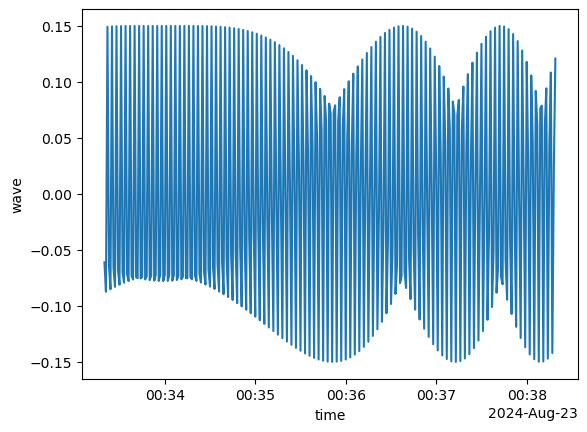

In [13]:
t= (ds_buoy2.time-ds_buoy2.time[0])*1e-9 # in seconds
ds_buoy2['tsec']=t.astype('float32')
ds_buoy2['wave'] = ds_buoy2.WVHT/2 * np.sin(2 * np.pi * ds_buoy2.tsec / ds_buoy2.APD)
ds_buoy2.wave[2000:2300].plot()

In [14]:
# Convert DataArray to DataFrame and SAVE to file
ds_buoy2=ds_buoy2.drop({'DEWP','VIS','PTDY','TIDE'})
df = ds_buoy2.to_dataframe()
df.to_csv("./data/buoy_data1sec.csv")